<a href="https://colab.research.google.com/github/tc3oliver/StratLabFreq/blob/dev/MACD_Divergence_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/StratLabFreq')
os.listdir()

['data', 'TaipeiSansTCBeta-Regular.ttf', 'MACD_Divergence_Analysis.ipynb']

In [2]:
import pandas as pd

In [3]:
dataframe = pd.read_json('./data/BTC_USDT-5m.json')
dataframe.columns=['date', 'open' , 'high', 'low', 'close', 'volume' ]
dataframe['date']=(pd.to_datetime(dataframe['date'],unit='ms'))
dataframe

,date,open,high,low,close,volume
0,2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061
1,2017-08-17 04:05:00,4261.48,4261.48,4261.48,4261.48,0.000000
2,2017-08-17 04:10:00,4261.48,4261.48,4261.48,4261.48,0.000000
3,2017-08-17 04:15:00,4261.48,4264.88,4261.48,4261.48,0.484666
4,2017-08-17 04:20:00,4264.88,4266.29,4264.88,4266.29,2.328570
...,...,...,...,...,...,...
617219,2023-07-06 05:50:00,30549.80,30569.99,30549.80,30563.11,105.865190
617220,2023-07-06 05:55:00,30563.11,30593.64,30563.11,30582.51,71.446400
617221,2023-07-06 06:00:00,30582.50,30599.30,30573.33,30575.48,88.509370
617222,2023-07-06 06:05:00,30575.48,30575.48,30560.00,30570.04,58.483620


In [4]:
!pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 1.9 MB/s eta 0:00:00


In [5]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.font_manager as fm
import matplotlib as mpl

# 下載字體
# !wget https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download -O TaipeiSansTCBeta-Regular.ttf

# 註冊字體
# font_path = 'TaipeiSansTCBeta-Regular.ttf'
# prop = fm.FontProperties(fname=font_path)
# 設定 matplotlib 字體
# mpl.rcParams['font.family'] = prop.get_name()
# font={'font.family': prop.get_name()}
# style=mpf.make_mpf_style(base_mpf_style='default', rc=font)

In [6]:
import random

count = 40

def get_random_count_values_dataframe(df):
    if len(df) < count:
        raise ValueError("DataFrame 中的資料數量不足 40 個")

    start_index = random.randint(0, len(df) - count)

    selected_values = df.iloc[start_index : start_index + count]

    selected_df = pd.DataFrame(selected_values)

    return selected_df

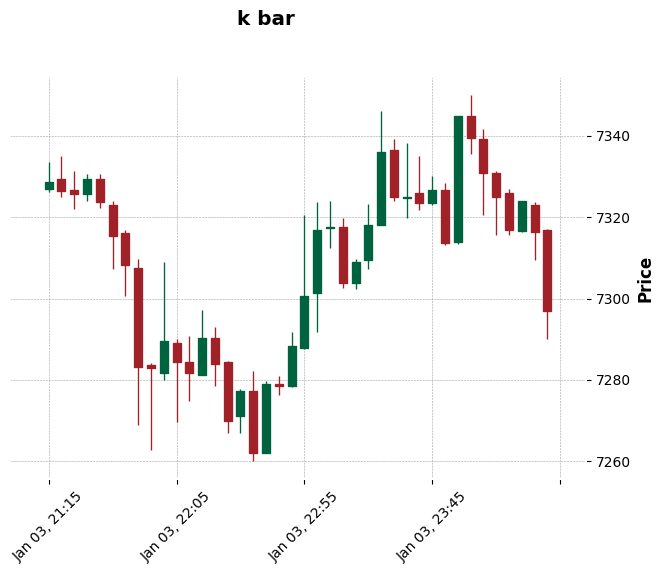

In [7]:
df = get_random_count_values_dataframe(dataframe)

# 將索引設定為 DatetimeIndex
df.set_index('date', inplace=True)

# 繪製 K 線圖
mpf.plot(df, type='candle', style='charles', title='k bar')

# 顯示圖表
plt.show()

In [8]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4287    0  4287    0     0   7912      0 --:--:-- --:--:-- --:--:--  7909
100  517k  100  517k    0     0   368k      0  0:00:01  0:00:01 --:--:-- 3228k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4291    0  4291    0     0  15265      0 --:--:-- --:--:-- --:--:-- 15325
100  392k  100  392k    0     0   380k      0  0:00:01  0:00:01 --:--:-- 2253k


In [9]:
import talib.abstract as ta

In [10]:
macd = ta.MACD(dataframe, fastperiod=13, slowperiod=34)
dataframe['macdhist'] = macd['macdhist']

In [11]:
# new
import statistics

# 尋找三個峰值且這些波峰連續升高
def find_peak_sequence(data):
    peaks_index = []
    wave = []

    for i in range(len(data)):
        if i == len(data) - 1:
            break
        d = abs(data[i])
        if len(wave) == 0 or d > wave[-1]:
            wave.append(d)
        else:
            if len(wave) > 1:
                peaks_index.append(i-1)
            wave = [d]

    if len(wave) > 0:
        peaks_index.append(i)

    highlighted_points = [(index, data[index]) for index in peaks_index]

    temp = highlighted_points[-1]

    # new
    if abs(statistics.mean(x[1] for x in highlighted_points[-5:-1])) > abs(temp[-1]):
      return False, []

    highlighted_points = highlighted_points[:-1]

    # new
    highlighted_points = [n for n in highlighted_points if n[1] < 0]

    highlighted_points = sorted(
        highlighted_points, key=lambda x: abs(x[1]), reverse=True)[:2]
    highlighted_points = sorted(
        highlighted_points, key=lambda x: x[0], reverse=False)
    highlighted_points.append(temp)

    if len(highlighted_points) >= 3:
        if abs(highlighted_points[-3][1]) > abs(highlighted_points[-2][1]) > abs(highlighted_points[-1][1]):
                return True, highlighted_points

    return False, []

# 多單條件檢查 零軸以下的 MACD 柱狀體應該大於 windows 的一半
def find_peak_sequence_logn_wrapper(data):
  if data[-1] > 0:
    return False, []
  count = sum(1 for value in data if value < 0)
  if count < (len(data) / 2):
      return False, []
  return find_peak_sequence(data)

In [12]:
import numpy as np

# dataframe['is_low_decreasing'] = dataframe['high'].rolling(window=count).apply(lambda x: x[-1] < max(x[:-1]), raw=True)
# dataframe['is_low_decreasing'] = dataframe['high'].rolling(window=count).apply(lambda x: x[-1] < x[0], raw=True)
dataframe['is_low_decreasing'] = dataframe['high'].rolling(window=count).apply(lambda x: (x[-1] < x[0]) & (x[-1] < max(x[:-1])), raw=True)


[-4.484053483574193, -4.935903615336649, -4.630277233857662, -4.861424320155486, -4.272039690610832, -3.118157882532394, -3.222484579172857, -2.3118220499057536, -2.183650400713905, -1.8038011326823167, -1.9638011980043117, -2.3554690723279634, -2.492857953585439, -3.1056663720832685, -3.94594946627946, -4.121132539283112, -4.392742917693841, -4.20058706690692, -4.212990027658554, -4.257639874812529, -3.5427538139564625, -3.2806030890794515, -2.6030592783141193, -1.782550134497125, -0.7739384264854463, 0.18198059887551832, 0.4955876958667593, 0.4606310271470413, 0.9828489317213638, 1.553617513382676, 0.952298445441329, 0.9756606292210561, 1.4496279640209107, 1.347849845973716, 0.628660869272565, -0.3830108242248009, -0.9253913723450662, -1.9620410632960485, -2.5663326693436774, -2.955770147298458]
[(1, -4.935903615336649), (3, -4.861424320155486), (39, -2.955770147298458)]


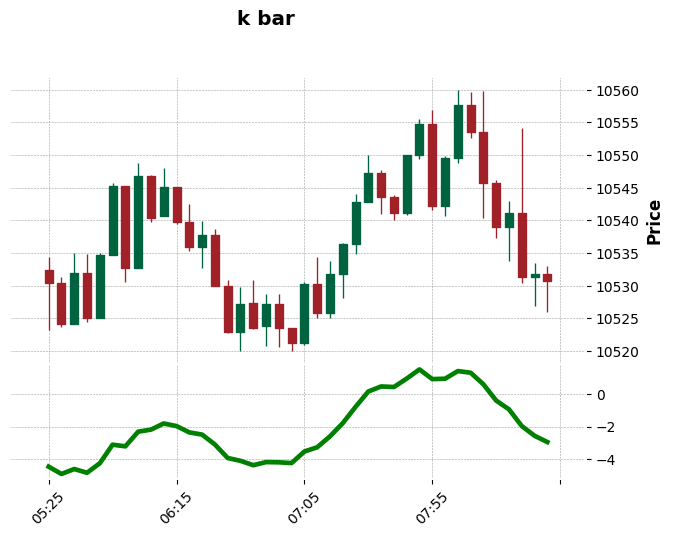

In [13]:
import numpy as np

while True:
  df = get_random_count_values_dataframe(dataframe)
  data = df['macdhist'].values.tolist()

  isfind, l = find_peak_sequence_logn_wrapper(data)


  if isfind:
    print(data)
    print(l)
    if df['is_low_decreasing'].values.tolist()[-1]:
      df.set_index('date', inplace=True)

      # 建立一個 MACD histogram 的圖像
      ap = mpf.make_addplot(df['macdhist'], panel=1, color='g', secondary_y=False)

      # 繪製 K 線圖，並添加 MACD histogram
      mpf.plot(df, type='candle', style='charles', title='k bar', addplot=ap)

      # 顯示圖表
      plt.show()

      break

In [14]:
df = get_random_count_values_dataframe(dataframe)
df.head()

,date,open,high,low,close,volume,macdhist,is_low_decreasing
427421,2021-09-15 02:00:00,47050.73,47109.80,47020.78,47050.38,107.12147,-40.741127,1.0
427422,2021-09-15 02:05:00,47050.39,47050.39,46974.66,46988.57,122.11424,-43.376384,1.0
427423,2021-09-15 02:10:00,46988.57,47037.86,46972.58,47022.84,85.12331,-41.162419,1.0
427424,2021-09-15 02:15:00,47022.84,47037.00,46999.66,47005.95,69.67674,-39.353597,1.0
427425,2021-09-15 02:20:00,47005.96,47069.01,46999.27,47039.20,65.56174,-34.385502,1.0


In [15]:
import numpy as np


dataframe['is_low_decreasing'] = dataframe['high'].rolling(window=count).apply(lambda x: (x[-1] < x[0]) & (x[-1] < max(x[:-1])), raw=True)


# Filter the DataFrame where 'is_low_decreasing' is True
filtered_df = dataframe[dataframe['is_low_decreasing'] == True]

# Print the filtered DataFrame
print(filtered_df)

                      date      open      high       low     close     volume  \
45     2017-08-17 07:45:00   4287.41   4287.41   4287.41   4287.41   0.004263   
105    2017-08-17 12:45:00   4430.00   4430.00   4411.00   4411.00   0.699498   
106    2017-08-17 12:50:00   4420.00   4431.13   4411.00   4411.00   0.147476   
107    2017-08-17 12:55:00   4411.00   4411.00   4411.00   4411.00   0.000000   
108    2017-08-17 13:00:00   4411.00   4430.00   4411.00   4430.00   0.610006   
...                    ...       ...       ...       ...       ...        ...   
617211 2023-07-06 05:10:00  30462.37  30462.37  30438.26  30438.27  83.211070   
617212 2023-07-06 05:15:00  30438.26  30460.80  30438.26  30458.45  51.660800   
617213 2023-07-06 05:20:00  30458.44  30464.11  30458.44  30464.11  24.107720   
617214 2023-07-06 05:25:00  30464.10  30480.69  30464.10  30480.69  40.571040   
617215 2023-07-06 05:30:00  30480.69  30499.99  30480.68  30499.99  34.391400   

        macdhist  is_low_de

In [39]:
# 尋找三個峰值且這些波峰連續升高
def find_peak_test(data):
        peaks_index = []
        wave = []

        for i in range(len(data)):
            if i == len(data) - 1:
                break
            d = abs(data[i])
            if len(wave) == 0 or d > wave[-1]:
                wave.append(d)
            else:
                if len(wave) > 1:
                    peaks_index.append(i-1)
                wave = [d]

        if len(wave) > 0:
            peaks_index.append(i)

        highlighted_points = [(index, data[index]) for index in peaks_index]

        temp = highlighted_points[-1]


        if len(highlighted_points) < 3:
            return False, []

        highlighted_points = highlighted_points[:-1]

        highlighted_points = sorted(
            highlighted_points, key=lambda x: abs(x[1]), reverse=True)[:2]
        highlighted_points = sorted(
            highlighted_points, key=lambda x: x[0], reverse=False)
        highlighted_points.append(temp)

        if len(highlighted_points) >= 3:
            if abs(highlighted_points[-3][1]) > abs(highlighted_points[-2][1]) > abs(highlighted_points[-1][1]):
                    return True, highlighted_points

        return False, []



In [40]:
# dataframe['is_high_decreasing'] = dataframe['high'].rolling(window=count).apply(lambda x: (x[-1] > x[0]) & (x[-1] > max(x[:-1])), raw=True)
# 判斷高點持續提高
max_open_close = pd.Series.max(dataframe[['open', 'close']], axis=1)
dataframe['is_high_increase'] = max_open_close.rolling(window=count).apply(lambda x: (x[-1] > x[0]) & (x[-1] > max(x[:-1])), raw=True)

# 空單條件檢查 零軸以上的 MACD 柱狀體應該大於 windows 的一半
def find_peak_sequence_short_wrapper(data):
            if data[-1] < 0:
                return False, []
            if abs(statistics.mean(x for x in data[-3:-1])) > abs(data[-1]):
                return False, []
            count = sum(1 for value in data if value > 0)
            if count < (len(data) / 2):
                return False, []
            return find_peak_test([n for n in data if n > 0])

[10.93949192398953, 9.218793236374866, 6.9400036513149885, 4.865887885929061, 2.222764982996436, 0.7188033672128977, -0.039218639137017064, 0.6379869612881883, 0.9108643842597957, 1.7095067839048514, 1.671823890469632, 2.096964898453786, 0.7293384327138899, -0.7977256333842195, -1.7593779481204717, -1.6230255769093773, -3.375680240794253, -5.006462418803107, -6.587457696041801, -6.430068580587584, -3.487271975480084, 1.086743782668247, 3.700940124444614, 4.893781644333364, 7.454699192125036, 9.220511719988885, 9.357586379888136, 9.411742941433717, 7.2639784983570745, 5.8315754036160445, 5.331323498495738, 5.387149103550101, 4.20993689764465, 3.4081376315331093, 2.4173177390472924, 1.71922937514878, 1.1717367434176778, 0.8944485534296254, 1.9959880134027452, 4.1056375570048385]
[(18, 9.411742941433717), (22, 5.387149103550101), (30, 4.1056375570048385)]


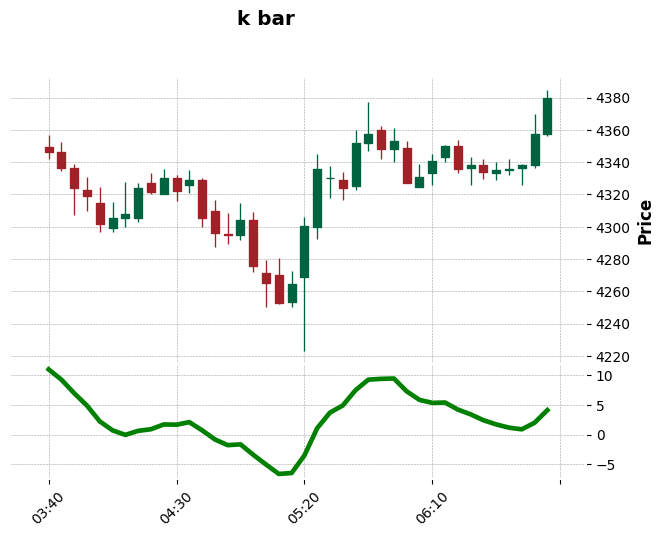

In [42]:


while True:

  df = get_random_count_values_dataframe(dataframe)
  data = df['macdhist'].values.tolist()



  isfind, l = find_peak_sequence_short_wrapper(data)


  if isfind:
    if df['is_high_increase'].values.tolist()[-1]:
      print(data)
      print(l)
      df.set_index('date', inplace=True)

      # 建立一個 MACD histogram 的圖像
      ap = mpf.make_addplot(df['macdhist'], panel=1, color='g', secondary_y=False)

      # 繪製 K 線圖，並添加 MACD histogram
      mpf.plot(df, type='candle', style='charles', title='k bar', addplot=ap)

      # 顯示圖表
      plt.show()

      break

In [34]:
# dataframe['is_low_decreasing'] = dataframe['low'].rolling(window=count).apply(lambda x: (x[-1] < x[0]) & (x[-1] < max(x[:-1])), raw=True)

In [43]:
# 判斷低點持續降低
min_open_close = pd.Series.min(dataframe[['open', 'close']], axis=1)
dataframe['is_low_decreasing'] = min_open_close.rolling(window=count).apply(lambda x: (x[-1] < x[0]) & (x[-1] < min(x[:-1])), raw=True)

# 多單條件檢查 零軸以下的 MACD 柱狀體應該大於 windows 的一半
def find_peak_sequence_logn_wrapper(data):
  if data[-1] > 0:
    return False, []
  count = sum(1 for value in data if value < 0)
  if count < (len(data) / 2):
      return False, []
  return find_peak_sequence(data)

[-8.61333897013327, -10.574200567662547, -9.837596463221816, -9.113665988867025, -8.796810093404165, -7.833747275935574, -7.295913093717338, -6.359523917990288, -6.777001519383271, -6.216672766786015, -5.366255935413662, -5.28342331258267, -5.256521825096161, -3.8835501313671923, -1.7676059801286037, 0.16469120783892066, 1.477058499752724, 3.4127737135200693, 4.911592331305725, 5.006231102024376, 4.406887804603073, 4.289892513535836, 5.120027489417307, 5.464309153275892, 5.28495005555136, 4.164408400347847, 2.152474409398936, 0.9168740435724674, -0.2839667278633522, -1.5732125812248405, -1.3979048654322153, -2.007935670348063, -1.7455587550924196, -1.130359552860547, -0.8380827879604853, -0.3843967388642202, -0.9610680662083793, -1.7547222368203128, -2.1804498670353833, -3.269284648766943]
[(1, -10.574200567662547), (8, -6.777001519383271), (39, -3.269284648766943)]


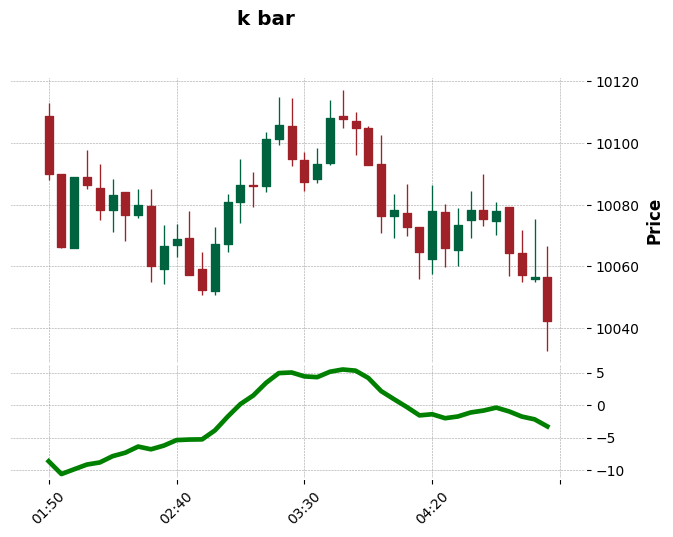

In [44]:
while True:

  df = get_random_count_values_dataframe(dataframe)
  data = df['macdhist'].values.tolist()



  isfind, l = find_peak_sequence_logn_wrapper(data)


  if isfind:

    if df['is_low_decreasing'].values.tolist()[-1]:
      print(data)
      print(l)
      df.set_index('date', inplace=True)

      # 建立一個 MACD histogram 的圖像
      ap = mpf.make_addplot(df['macdhist'], panel=1, color='g', secondary_y=False)

      # 繪製 K 線圖，並添加 MACD histogram
      mpf.plot(df, type='candle', style='charles', title='k bar', addplot=ap)

      # 顯示圖表
      plt.show()

      break

In [46]:
!git status

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [ ]:
!